In [2]:
# Tesla Stock Prediction with Sentiment Analysis - Complete Step-by-Step Guide
# Enhanced version with hybrid modeling, comprehensive evaluation, and advanced visualizations

# =============================================================================
# STEP 1: INSTALL AND IMPORT REQUIRED LIBRARIES
# =============================================================================
print("=" * 80)
print("🚀 TESLA STOCK PREDICTION WITH SENTIMENT ANALYSIS")
print("=" * 80)
print("Step 1: Setting up libraries and imports...")

🚀 TESLA STOCK PREDICTION WITH SENTIMENT ANALYSIS
Step 1: Setting up libraries and imports...


In [3]:
!pip install yfinance newsapi-python transformers torch scikit-learn matplotlib seaborn
!pip install statsmodels pandas numpy scipy plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
# Import all required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
from newsapi import NewsApiClient
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [5]:
# =============================================================================
# STEP 2: CONFIGURATION AND SETUP
# =============================================================================
print("\nStep 2: Configuration and global settings...")

# Configuration parameters
TICKER = 'TSLA'
START_DATE = '2023-01-01'
END_DATE = datetime.date.today().strftime('%Y-%m-%d')
NEWS_API_KEY = 'db6392cd469e429180c78d2a88867b94'  # Replace with your NewsAPI key
SEQUENCE_LENGTH = 10
TEST_SIZE = 30
LSTM_EPOCHS = 100
BATCH_SIZE = 32

# Global variables for storing results
stock_data = None
sentiment_data = None
merged_data = None
scaler = MinMaxScaler()
models = {}
predictions = {}
performance_metrics = {}

print(f"✅ Configuration set for {TICKER} from {START_DATE} to {END_DATE}")



Step 2: Configuration and global settings...
✅ Configuration set for TSLA from 2023-01-01 to 2025-07-31



Step 3: Fetching and processing Tesla stock data...
📈 Downloading TSLA data...


[*********************100%***********************]  1 of 1 completed


✅ Successfully processed 616 days of stock data
📊 Stock Data Summary:
   Date Range: 2023-02-14 00:00:00 to 2025-07-30 00:00:00
   Current Price: $319.04
   52-Week High: $488.54
   52-Week Low: $138.80
   Average Volume: 110,383,288

First 5 rows:
                  Open        High         Low       Close     Volume  \
Date                                                                    
2023-02-14  191.940002  209.820007  189.440002  209.250000  216455700   
2023-02-15  211.759995  214.660004  206.110001  214.240005  181006400   
2023-02-16  210.779999  217.649994  201.839996  202.039993  229586500   
2023-02-17  199.990005  208.440002  197.500000  208.309998  213738500   
2023-02-21  204.990005  209.710007  197.220001  197.369995  180018600   

             Returns  Volatility       MA_10       MA_30        RSI  \
Date                                                                  
2023-02-14  0.075062    0.033936  196.062000  154.817999  78.767977   
2023-02-15  0.023847    0.

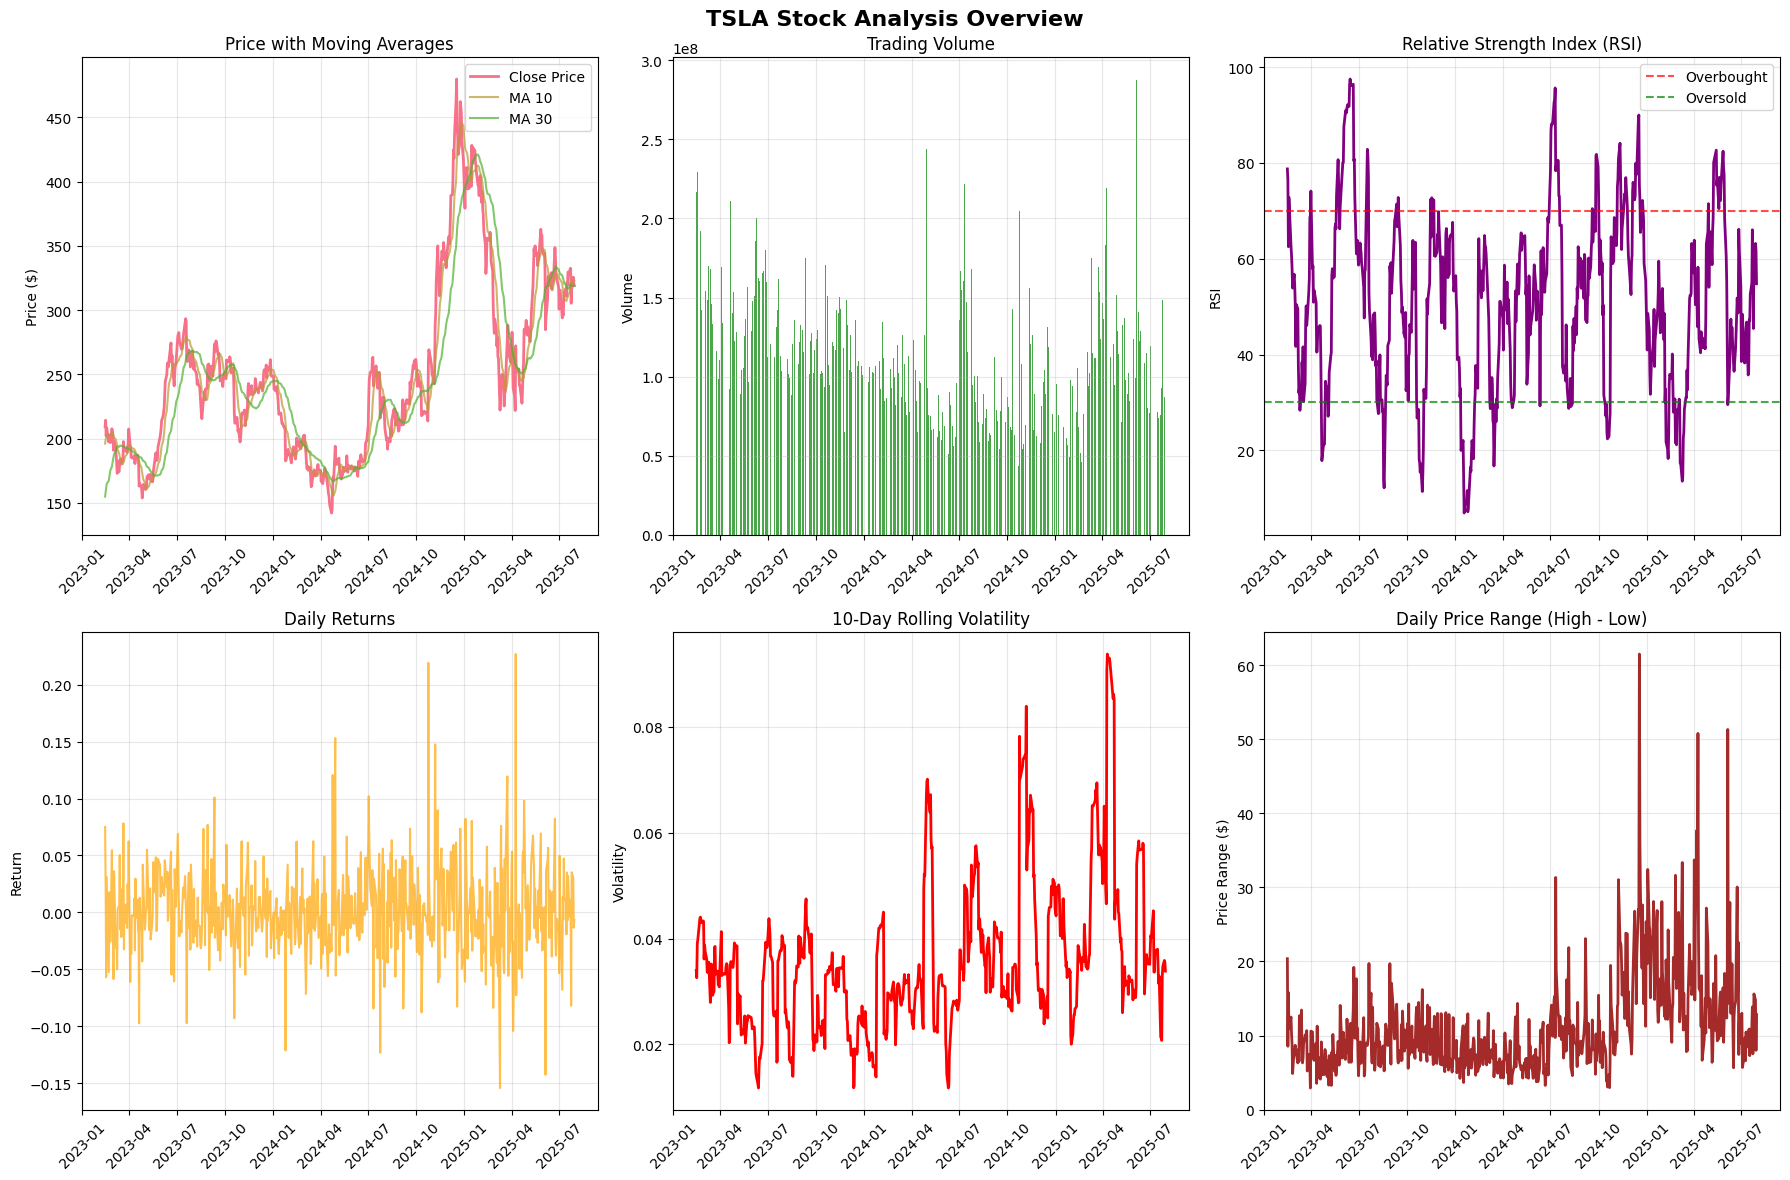

In [6]:
# =============================================================================
# STEP 3: FETCH AND PROCESS STOCK DATA
# =============================================================================
print("\nStep 3: Fetching and processing Tesla stock data...")

def fetch_stock_data(ticker, start_date, end_date):
    """Fetch stock data with technical indicators"""
    try:
        print(f"📈 Downloading {ticker} data...")
        raw_data = yf.download(ticker, start=start_date, end=end_date)

        # Handle multi-index columns
        if isinstance(raw_data.columns, pd.MultiIndex):
            data = pd.DataFrame({
                'Open': raw_data[('Open', ticker)],
                'High': raw_data[('High', ticker)],
                'Low': raw_data[('Low', ticker)],
                'Close': raw_data[('Close', ticker)],
                'Volume': raw_data[('Volume', ticker)]
            })
        else:
            data = raw_data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

        # Add technical indicators
        data['Returns'] = data['Close'].pct_change()
        data['Volatility'] = data['Returns'].rolling(window=10).std()
        data['MA_10'] = data['Close'].rolling(window=10).mean()
        data['MA_30'] = data['Close'].rolling(window=30).mean()
        data['RSI'] = calculate_rsi(data['Close'])
        data['Price_Range'] = data['High'] - data['Low']

        # Remove NaN values
        data.dropna(inplace=True)

        print(f"✅ Successfully processed {len(data)} days of stock data")
        return data

    except Exception as e:
        print(f"❌ Error fetching stock data: {e}")
        return None

def calculate_rsi(prices, window=14):
    """Calculate Relative Strength Index"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Fetch the stock data
stock_data = fetch_stock_data(TICKER, START_DATE, END_DATE)

if stock_data is not None:
    print(f"📊 Stock Data Summary:")
    print(f"   Date Range: {stock_data.index[0]} to {stock_data.index[-1]}")
    print(f"   Current Price: ${stock_data['Close'][-1]:.2f}")
    print(f"   52-Week High: ${stock_data['High'].max():.2f}")
    print(f"   52-Week Low: ${stock_data['Low'].min():.2f}")
    print(f"   Average Volume: {stock_data['Volume'].mean():,.0f}")

    # Display first and last few rows
    print("\nFirst 5 rows:")
    print(stock_data.head())
    print("\nLast 5 rows:")
    print(stock_data.tail())
else:
    print("❌ Failed to fetch stock data. Exiting...")
    exit()
# =============================================================================
# STEP 4: VISUALIZE STOCK DATA
# =============================================================================
print("\nStep 4: Creating stock data visualizations...")

def plot_stock_overview(data):
    """Create comprehensive stock data visualization"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{TICKER} Stock Analysis Overview', fontsize=16, fontweight='bold')

    # 1. Price and Moving Averages
    axes[0,0].plot(data.index, data['Close'], label='Close Price', linewidth=2)
    axes[0,0].plot(data.index, data['MA_10'], label='MA 10', alpha=0.7)
    axes[0,0].plot(data.index, data['MA_30'], label='MA 30', alpha=0.7)
    axes[0,0].set_title('Price with Moving Averages')
    axes[0,0].set_ylabel('Price ($)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Volume
    axes[0,1].bar(data.index, data['Volume'], alpha=0.7, color='green')
    axes[0,1].set_title('Trading Volume')
    axes[0,1].set_ylabel('Volume')
    axes[0,1].grid(True, alpha=0.3)

    # 3. RSI
    axes[0,2].plot(data.index, data['RSI'], color='purple', linewidth=2)
    axes[0,2].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
    axes[0,2].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
    axes[0,2].set_title('Relative Strength Index (RSI)')
    axes[0,2].set_ylabel('RSI')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # 4. Daily Returns
    axes[1,0].plot(data.index, data['Returns'], alpha=0.7, color='orange')
    axes[1,0].set_title('Daily Returns')
    axes[1,0].set_ylabel('Return')
    axes[1,0].grid(True, alpha=0.3)

    # 5. Volatility
    axes[1,1].plot(data.index, data['Volatility'], color='red', linewidth=2)
    axes[1,1].set_title('10-Day Rolling Volatility')
    axes[1,1].set_ylabel('Volatility')
    axes[1,1].grid(True, alpha=0.3)

    # 6. Price Range
    axes[1,2].plot(data.index, data['Price_Range'], color='brown', linewidth=2)
    axes[1,2].set_title('Daily Price Range (High - Low)')
    axes[1,2].set_ylabel('Price Range ($)')
    axes[1,2].grid(True, alpha=0.3)

    # Rotate x-axis labels for better readability
    for ax in axes.flat:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

# Create stock visualization
plot_stock_overview(stock_data)


In [ ]:
# =============================================================================
# STEP 5: FETCH AND ANALYZE NEWS SENTIMENT
# =============================================================================
print("\nStep 5: Fetching news data and analyzing sentiment...")

def load_sentiment_model():
    """Load FinBERT sentiment analysis model"""
    try:
        print("🎭 Loading FinBERT sentiment model...")
        tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
        model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
        print("✅ FinBERT model loaded successfully")
        return tokenizer, model, True
    except Exception as e:
        print(f"⚠️ Error loading FinBERT: {e}")
        print("Will use synthetic sentiment data...")
        return None, None, False

def fetch_news_sentiment(api_key, days_back=30):
    """Fetch news and analyze sentiment"""
    tokenizer, sentiment_model, model_loaded = load_sentiment_model()

    try:
        print(f"📰 Fetching Tesla news from last {days_back} days...")
        newsapi = NewsApiClient(api_key=api_key)
        today = datetime.date.today()
        from_date = today - datetime.timedelta(days=days_back)

        all_articles = newsapi.get_everything(
            q='Tesla TSLA',
            language='en',
            sort_by='relevancy',
            from_param=from_date.isoformat(),
            to=today.isoformat(),
            page_size=100
        )

        if not all_articles['articles']:
            raise Exception("No articles found")

        news_df = pd.DataFrame(all_articles['articles'])
        news_df['publishedAt'] = pd.to_datetime(news_df['publishedAt']).dt.date
        news_df = news_df[['publishedAt', 'title', 'description']].dropna()

        def analyze_sentiment(text):
            if not model_loaded:
                return np.random.uniform(-0.5, 0.5)
            try:
                inputs = tokenizer(str(text), return_tensors="pt", truncation=True, max_length=512)
                with torch.no_grad():
                    outputs = sentiment_model(**inputs)
                probs = softmax(outputs.logits, dim=1)
                # FinBERT outputs: [negative, neutral, positive]
                return probs[0][2].item() - probs[0][0].item()  # positive - negative
            except:
                return 0.0

        print("🔍 Analyzing sentiment of news articles...")
        news_df['sentiment_score'] = news_df['title'].apply(analyze_sentiment)

        # Aggregate daily sentiment
        daily_sentiment = news_df.groupby('publishedAt').agg({
            'sentiment_score': ['mean', 'std', 'count']
        }).reset_index()

        daily_sentiment.columns = ['Date', 'Sentiment_Mean', 'Sentiment_Std', 'Sentiment_Count']
        daily_sentiment['Sentiment_Std'].fillna(0, inplace=True)
        daily_sentiment.set_index('Date', inplace=True)

        print(f"✅ Processed {len(news_df)} articles across {len(daily_sentiment)} days")

        # Display sample headlines with sentiment
        print("\n📰 Sample Headlines with Sentiment Scores:")
        sample_news = news_df.nlargest(5, 'sentiment_score')[['title', 'sentiment_score']]
        for _, row in sample_news.iterrows():
            sentiment_label = "📈 Positive" if row['sentiment_score'] > 0.1 else "📉 Negative" if row['sentiment_score'] < -0.1 else "📊 Neutral"
            print(f"{sentiment_label} ({row['sentiment_score']:+.3f}): {row['title'][:80]}...")

        return daily_sentiment, news_df, model_loaded

    except Exception as e:
        print(f"⚠️ Error with news API: {e}")
        print("Creating synthetic sentiment data...")

        # Create synthetic sentiment data
        date_range = pd.date_range(start=stock_data.index[0], end=stock_data.index[-1], freq='D')
        synthetic_sentiment = pd.DataFrame({
            'Date': [d.date() for d in date_range],
            'Sentiment_Mean': np.random.normal(0, 0.3, len(date_range)),
            'Sentiment_Std': np.random.uniform(0.1, 0.5, len(date_range)),
            'Sentiment_Count': np.random.randint(1, 5, len(date_range))
        })
        synthetic_sentiment.set_index('Date', inplace=True)

        # Create dummy news data
        dummy_news = pd.DataFrame({
            'publishedAt': synthetic_sentiment.index,
            'title': [f'Tesla news headline {i}' for i in range(len(synthetic_sentiment))],
            'sentiment_score': synthetic_sentiment['Sentiment_Mean'].values
        })

        return synthetic_sentiment, dummy_news, False

# Fetch sentiment data
sentiment_data, news_df, sentiment_model_loaded = fetch_news_sentiment(NEWS_API_KEY)

print(f"\n📊 Sentiment Analysis Summary:")
print(f"   Average Sentiment: {sentiment_data['Sentiment_Mean'].mean():.3f}")
print(f"   Sentiment Range: {sentiment_data['Sentiment_Mean'].min():.3f} to {sentiment_data['Sentiment_Mean'].max():.3f}")
print(f"   Most Positive Day: {sentiment_data['Sentiment_Mean'].idxmax()} ({sentiment_data['Sentiment_Mean'].max():.3f})")
print(f"   Most Negative Day: {sentiment_data['Sentiment_Mean'].idxmin()} ({sentiment_data['Sentiment_Mean'].min():.3f})")



Step 5: Fetching news data and analyzing sentiment...
🎭 Loading FinBERT sentiment model...


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

✅ FinBERT model loaded successfully
📰 Fetching Tesla news from last 30 days...


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

🔍 Analyzing sentiment of news articles...
✅ Processed 94 articles across 25 days

📰 Sample Headlines with Sentiment Scores:
📈 Positive (+1.000): Tesla (TSLA) Gets $285 PT, Neutral — Goldman Flags Weaker U.S. EV Demand...
📈 Positive (+1.000): Tesla's German car sales continue to fall in June...
📈 Positive (+1.000): Tesla stock slides after earnings miss, Musk warns of 'few rough quarters'...
📈 Positive (+1.000): Tesla stock slides after earnings miss, Musk warns of 'few rough quarters'...
📈 Positive (+1.000): Earnings live: Tesla results miss, Google boosts AI spending, Chipotle plunges...

📊 Sentiment Analysis Summary:
   Average Sentiment: -0.465
   Sentiment Range: -1.000 to 0.267
   Most Positive Day: 2025-07-18 (0.267)
   Most Negative Day: 2025-07-04 (-1.000)


In [ ]:
# =============================================================================
# STEP 6: MERGE STOCK DATA WITH SENTIMENT DATA
# =============================================================================
print("\nStep 6: Merging stock and sentiment data...")

def merge_data(stock_df, sentiment_df):
    """Merge stock data with sentiment data"""
    print("🔄 Merging datasets...")
    merged = pd.merge(stock_df, sentiment_df, how='left', left_index=True, right_index=True)

    # Fill missing sentiment values with neutral (0)
    sentiment_cols = ['Sentiment_Mean', 'Sentiment_Std', 'Sentiment_Count']
    for col in sentiment_cols:
        if col in merged.columns:
            merged[col].fillna(0, inplace=True)

    print(f"✅ Merged dataset created with {len(merged)} rows and {len(merged.columns)} columns")
    return merged

merged_data = merge_data(stock_data, sentiment_data)

# Calculate correlation between price and sentiment
price_sentiment_corr = merged_data['Close'].corr(merged_data['Sentiment_Mean'])
print(f"\n📈 Price-Sentiment Correlation: {price_sentiment_corr:.4f}")

correlation_strength = "Very Strong" if abs(price_sentiment_corr) > 0.7 else \
                      "Strong" if abs(price_sentiment_corr) > 0.5 else \
                      "Moderate" if abs(price_sentiment_corr) > 0.3 else \
                      "Weak"
correlation_direction = "Positive" if price_sentiment_corr > 0 else "Negative"
print(f"   Interpretation: {correlation_strength} {correlation_direction} correlation")

print("\nMerged data sample (last 10 days):")
print(merged_data.tail(10)[['Close', 'Volume', 'Sentiment_Mean', 'Sentiment_Count']])



Step 6: Merging stock and sentiment data...
🔄 Merging datasets...
✅ Merged dataset created with 615 rows and 14 columns

📈 Price-Sentiment Correlation: -0.1167
   Interpretation: Weak Negative correlation

Merged data sample (last 10 days):
                 Close     Volume  Sentiment_Mean  Sentiment_Count
Date                                                              
2025-07-16  321.670013   97284800       -0.784825              3.0
2025-07-17  319.410004   73922900        0.000000              0.0
2025-07-18  329.649994   94255000        0.267326              2.0
2025-07-21  328.489990   75768800       -0.401580              5.0
2025-07-22  332.109985   77370400       -0.324929              5.0
2025-07-23  332.559998   92553800       -0.506962              9.0
2025-07-24  305.299988  156966000        0.213776              6.0
2025-07-25  316.059998  148227000        0.008569              4.0
2025-07-28  325.589996  112673800       -0.977173              2.0
2025-07-29  321.20001


Step 7: Creating sentiment analysis visualizations...


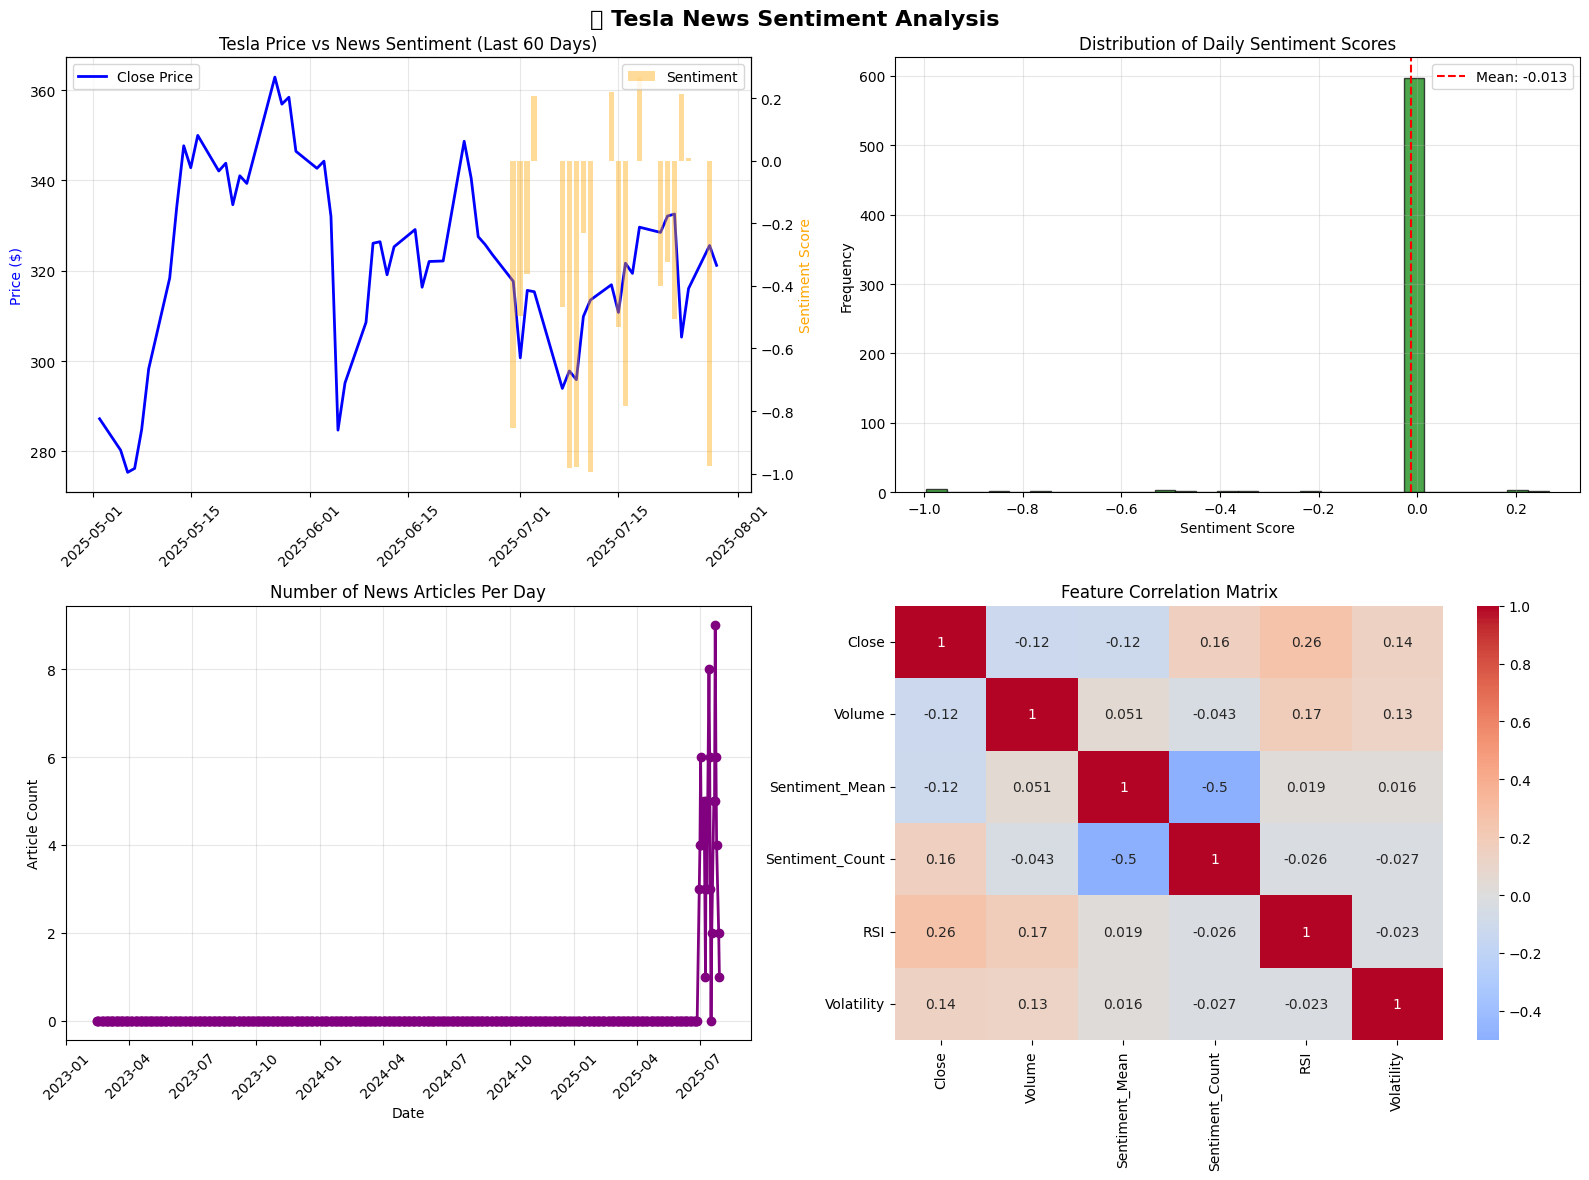

In [ ]:
# =============================================================================
# STEP 7: VISUALIZE SENTIMENT ANALYSIS
# =============================================================================
print("\nStep 7: Creating sentiment analysis visualizations...")

def plot_sentiment_analysis(merged_df, news_df):
    """Create comprehensive sentiment visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📰 Tesla News Sentiment Analysis', fontsize=16, fontweight='bold')

    # 1. Price vs Sentiment over time
    ax1 = axes[0,0]
    ax1_twin = ax1.twinx()

    recent_data = merged_df.tail(60)  # Last 60 days
    line1 = ax1.plot(recent_data.index, recent_data['Close'], 'b-', linewidth=2, label='Close Price')
    bars = ax1_twin.bar(recent_data.index, recent_data['Sentiment_Mean'],
                       alpha=0.4, color='orange', label='Sentiment')

    ax1.set_title('Tesla Price vs News Sentiment (Last 60 Days)')
    ax1.set_ylabel('Price ($)', color='blue')
    ax1_twin.set_ylabel('Sentiment Score', color='orange')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    # 2. Sentiment distribution
    axes[0,1].hist(merged_df['Sentiment_Mean'].dropna(), bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0,1].axvline(merged_df['Sentiment_Mean'].mean(), color='red', linestyle='--',
                     label=f'Mean: {merged_df["Sentiment_Mean"].mean():.3f}')
    axes[0,1].set_title('Distribution of Daily Sentiment Scores')
    axes[0,1].set_xlabel('Sentiment Score')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. News count over time
    axes[1,0].plot(merged_df.index, merged_df['Sentiment_Count'], marker='o', linewidth=2, color='purple')
    axes[1,0].set_title('Number of News Articles Per Day')
    axes[1,0].set_ylabel('Article Count')
    axes[1,0].set_xlabel('Date')
    axes[1,0].grid(True, alpha=0.3)
    plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=45)

    # 4. Correlation heatmap
    corr_data = merged_df[['Close', 'Volume', 'Sentiment_Mean', 'Sentiment_Count', 'RSI', 'Volatility']].corr()
    sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
    axes[1,1].set_title('Feature Correlation Matrix')

    plt.tight_layout()
    plt.show()

# Create sentiment visualization
plot_sentiment_analysis(merged_data, news_df)

In [ ]:
# =============================================================================
# STEP 8: PREPARE DATA FOR MACHINE LEARNING
# =============================================================================
print("\nStep 8: Preparing data for machine learning models...")

def prepare_ml_data(data, features=None, sequence_length=10, test_size=30):
    """Prepare data for LSTM and ARIMA models"""
    if features is None:
        features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment_Mean']

    # Ensure all features exist in the dataset
    available_features = [f for f in features if f in data.columns]
    if len(available_features) != len(features):
        print(f"⚠️ Some features not available. Using: {available_features}")
        features = available_features

    print(f"📊 Using features: {features}")

    # Select and clean data
    ml_data = data[features].dropna()
    print(f"✅ Prepared {len(ml_data)} samples with {len(features)} features")

    return ml_data, features

# Prepare the data
ml_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment_Mean', 'RSI', 'Volatility']
ml_data, final_features = prepare_ml_data(merged_data, ml_features, SEQUENCE_LENGTH, TEST_SIZE)

print(f"📈 ML Data Shape: {ml_data.shape}")
print(f"📅 Date Range: {ml_data.index[0]} to {ml_data.index[-1]}")
print("\nFirst 5 rows of ML data:")
print(ml_data.head())


Step 8: Preparing data for machine learning models...
📊 Using features: ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment_Mean', 'RSI', 'Volatility']
✅ Prepared 615 samples with 8 features
📈 ML Data Shape: (615, 8)
📅 Date Range: 2023-02-14 00:00:00 to 2025-07-29 00:00:00

First 5 rows of ML data:
                  Open        High         Low       Close     Volume  \
Date                                                                    
2023-02-14  191.940002  209.820007  189.440002  209.250000  216455700   
2023-02-15  211.759995  214.660004  206.110001  214.240005  181006400   
2023-02-16  210.779999  217.649994  201.839996  202.039993  229586500   
2023-02-17  199.990005  208.440002  197.500000  208.309998  213738500   
2023-02-21  204.990005  209.710007  197.220001  197.369995  180018600   

            Sentiment_Mean        RSI  Volatility  
Date                                               
2023-02-14             0.0  78.767977    0.033936  
2023-02-15             0.0  7

In [ ]:
# =============================================================================
# STEP 9: TRADITIONAL ARIMA MODEL
# =============================================================================
print("\nStep 9: Building and training ARIMA model...")

def train_arima_model(data, test_size=30):
    """Train ARIMA model for price prediction"""
    print("📊 Training ARIMA model...")

    # Use close prices for ARIMA
    prices = data['Close'].dropna()
    train_size = len(prices) - test_size
    train_data = prices[:train_size]
    test_data = prices[train_size:]

    print(f"   Training data: {len(train_data)} samples")
    print(f"   Test data: {len(test_data)} samples")

    # Check stationarity
    adf_result = adfuller(train_data)
    print(f"   ADF Statistic: {adf_result[0]:.4f}")
    print(f"   p-value: {adf_result[1]:.4f}")

    if adf_result[1] <= 0.05:
        print("   ✅ Data is stationary")
    else:
        print("   ⚠️ Data may not be stationary, ARIMA will handle differencing")

    try:
        # Fit ARIMA model (using fixed order for simplicity)
        model = ARIMA(train_data, order=(5, 1, 1))
        fitted_model = model.fit()

        print("   ✅ ARIMA model fitted successfully")
        print(f"   AIC: {fitted_model.aic:.2f}")
        print(f"   BIC: {fitted_model.bic:.2f}")

        # Generate predictions
        train_pred = fitted_model.fittedvalues
        test_pred = fitted_model.forecast(steps=test_size)

        # Store results
        arima_results = {
            'model': fitted_model,
            'train_pred': train_pred.values,
            'test_pred': test_pred.values,
            'train_actual': train_data.values[1:],  # Skip first due to differencing
            'test_actual': test_data.values,
            'train_dates': train_data.index[1:],
            'test_dates': test_data.index
        }

        return arima_results, True

    except Exception as e:
        print(f"   ❌ Error training ARIMA model: {e}")
        return None, False

# Train ARIMA model
arima_results, arima_success = train_arima_model(ml_data, TEST_SIZE)

if arima_success:
    # Calculate ARIMA performance metrics
    arima_mse = mean_squared_error(arima_results['test_actual'], arima_results['test_pred'])
    arima_mae = mean_absolute_error(arima_results['test_actual'], arima_results['test_pred'])
    arima_rmse = np.sqrt(arima_mse)

    print(f"📊 ARIMA Performance:")
    print(f"   MSE: {arima_mse:.2f}")
    print(f"   MAE: {arima_mae:.2f}")
    print(f"   RMSE: {arima_rmse:.2f}")

    models['arima'] = arima_results['model']
    predictions['arima'] = arima_results


Step 9: Building and training ARIMA model...
📊 Training ARIMA model...
   Training data: 585 samples
   Test data: 30 samples
   ADF Statistic: -1.6551
   p-value: 0.4544
   ⚠️ Data may not be stationary, ARIMA will handle differencing
   ✅ ARIMA model fitted successfully
   AIC: 4360.61
   BIC: 4391.20
📊 ARIMA Performance:
   MSE: 182.02
   MAE: 10.35
   RMSE: 13.49


In [ ]:
# =============================================================================
# STEP 10: LSTM MODEL ARCHITECTURE
# =============================================================================
print("\nStep 10: Building LSTM neural network model...")

class EnhancedLSTM(nn.Module):
    """Enhanced LSTM model with attention mechanism"""
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(EnhancedLSTM, self).__init__()

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            hidden_size, num_heads=4, batch_first=True, dropout=dropout
        )

        # Normalization and regularization
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

        # Output layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Apply attention mechanism
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)

        # Add residual connection and layer normalization
        attn_out = self.layer_norm(attn_out + lstm_out)

        # Use the last time step
        out = self.dropout(attn_out[:, -1, :])

        # Pass through fully connected layers
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)

        return out

def create_sequences(data, seq_len=10):
    """Create sequences for LSTM training"""
    sequences = []
    targets = []

    for i in range(seq_len, len(data)):
        sequences.append(data[i-seq_len:i])
        targets.append(data[i, final_features.index('Close')])  # Close price target

    return np.array(sequences), np.array(targets)

# Prepare LSTM data
print("🔧 Preparing LSTM training data...")

# Scale the data
scaled_data = scaler.fit_transform(ml_data)
print(f"   ✅ Data scaled using MinMaxScaler")
print(f"   Scaled data shape: {scaled_data.shape}")

# Create sequences
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)
print(f"   ✅ Created {len(X)} sequences of length {SEQUENCE_LENGTH}")

# Split into train/test
train_size = len(X) - TEST_SIZE
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"   Training sequences: {X_train.shape}")
print(f"   Test sequences: {X_test.shape}")


Step 10: Building LSTM neural network model...
🔧 Preparing LSTM training data...
   ✅ Data scaled using MinMaxScaler
   Scaled data shape: (615, 8)
   ✅ Created 605 sequences of length 10
   Training sequences: (575, 10, 8)
   Test sequences: (30, 10, 8)


In [ ]:
# =============================================================================
# STEP 11: TRAIN LSTM MODEL
# =============================================================================
print("\nStep 11: Training LSTM model...")

def train_lstm_model(X_train, y_train, X_test, y_test, epochs=100):
    """Comprehensive LSTM training with monitoring"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🔧 Training LSTM on device: {device}")

    # Create model
    input_size = X_train.shape[2]
    model = EnhancedLSTM(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.2)
    model = model.to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   Model parameters: {total_params:,} (trainable: {trainable_params:,})")

    # Training setup
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=10, factor=0.5, verbose=True
    )
    criterion = nn.MSELoss()

    # Data loader
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Training monitoring
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 20

    print(f"🚀 Starting training for {epochs} epochs...")
    print("-" * 60)

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        batch_count = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_x).squeeze()
            loss = criterion(outputs, batch_y)

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_train_loss += loss.item()
            batch_count += 1

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(torch.FloatTensor(X_test).to(device)).cpu().numpy()
            val_loss = mean_squared_error(y_test, val_outputs.squeeze())

        # Record losses
        avg_train_loss = epoch_train_loss / batch_count
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping logic
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        # Print progress
        if (epoch + 1) % 20 == 0 or epoch == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"LR: {current_lr:.6f}")

        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    model.load_state_dict(best_model_state)
    print(f"✅ LSTM training completed! Best validation loss: {best_loss:.6f}")

    # Final predictions
    model.eval()
    with torch.no_grad():
        train_pred = model(torch.FloatTensor(X_train).to(device)).cpu().numpy()
        test_pred = model(torch.FloatTensor(X_test).to(device)).cpu().numpy()

    lstm_results = {
        'model': model,
        'train_pred': train_pred.squeeze(),
        'test_pred': test_pred.squeeze(),
        'train_actual': y_train,
        'test_actual': y_test,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'scaler': scaler
    }

    return lstm_results

# Train the LSTM model
lstm_results = train_lstm_model(X_train, y_train, X_test, y_test, LSTM_EPOCHS)

# Store results
models['lstm'] = lstm_results['model']
predictions['lstm'] = lstm_results

print("✅ LSTM model training completed!")



Step 11: Training LSTM model...
🔧 Training LSTM on device: cuda
   Model parameters: 71,617 (trainable: 71,617)
🚀 Starting training for 100 epochs...
------------------------------------------------------------
Epoch   1/100 | Train Loss: 0.041359 | Val Loss: 0.028662 | LR: 0.001000
Epoch  20/100 | Train Loss: 0.005605 | Val Loss: 0.002647 | LR: 0.001000
Epoch  40/100 | Train Loss: 0.005128 | Val Loss: 0.009216 | LR: 0.000500
Epoch  60/100 | Train Loss: 0.003530 | Val Loss: 0.002734 | LR: 0.000125
Early stopping triggered at epoch 69
✅ LSTM training completed! Best validation loss: 0.001392
✅ LSTM model training completed!



Step 12: Visualizing LSTM training progress...


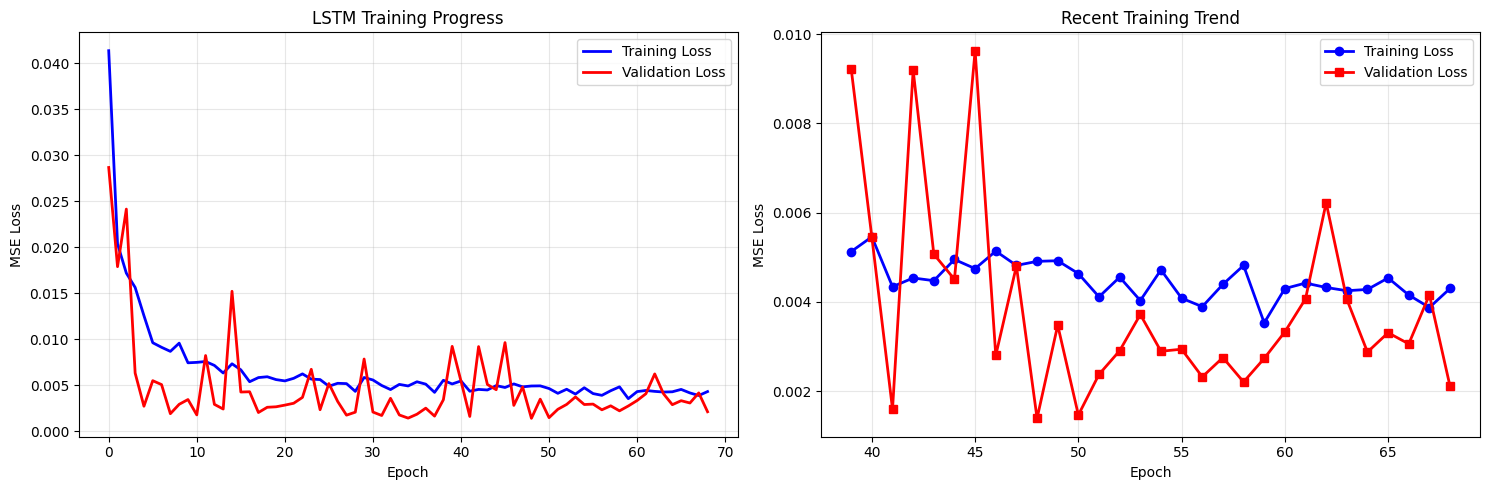

In [ ]:
# =============================================================================
# STEP 12: VISUALIZE TRAINING PROGRESS
# =============================================================================
print("\nStep 12: Visualizing LSTM training progress...")

def plot_training_progress(train_losses, val_losses):
    """Plot LSTM training progress"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Training and validation loss
    axes[0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    axes[0].plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    axes[0].set_title('LSTM Training Progress')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Recent training trend (last 30 epochs)
    recent_epochs = min(30, len(train_losses))
    recent_train = train_losses[-recent_epochs:]
    recent_val = val_losses[-recent_epochs:]

    axes[1].plot(range(len(train_losses)-recent_epochs, len(train_losses)),
                recent_train, label='Training Loss', color='blue', linewidth=2, marker='o')
    axes[1].plot(range(len(val_losses)-recent_epochs, len(val_losses)),
                recent_val, label='Validation Loss', color='red', linewidth=2, marker='s')
    axes[1].set_title('Recent Training Trend')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MSE Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training progress
plot_training_progress(lstm_results['train_losses'], lstm_results['val_losses'])

In [ ]:
# =============================================================================
# STEP 13: MODEL PREDICTIONS AND EVALUATION
# =============================================================================
print("\nStep 13: Generating predictions and evaluating models...")

def convert_lstm_predictions_to_price(scaled_predictions, scaler, feature_names):
    """Convert scaled LSTM predictions back to actual prices"""
    # Create dummy array for inverse transform
    dummy_array = np.zeros((len(scaled_predictions), len(feature_names)))
    close_idx = feature_names.index('Close')
    dummy_array[:, close_idx] = scaled_predictions

    # Inverse transform
    unscaled = scaler.inverse_transform(dummy_array)
    return unscaled[:, close_idx]

def calculate_comprehensive_metrics(y_true, y_pred, model_name):
    """Calculate comprehensive performance metrics"""
    # Ensure same length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    # Basic metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # Additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Directional accuracy
    if len(y_true) > 1:
        true_directions = np.diff(y_true) > 0
        pred_directions = np.diff(y_pred) > 0
        directional_accuracy = np.mean(true_directions == pred_directions) * 100
    else:
        directional_accuracy = 0

    # Relative metrics
    mean_price = np.mean(y_true)
    relative_rmse = (rmse / mean_price) * 100

    metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2,
        'Directional_Accuracy': directional_accuracy,
        'Relative_RMSE': relative_rmse,
        'Mean_Price': mean_price
    }

    print(f"📊 {model_name} Performance Metrics:")
    print(f"   MSE: {mse:.2f}")
    print(f"   MAE: {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R² Score: {r2:.4f}")
    print(f"   Directional Accuracy: {directional_accuracy:.1f}%")
    print(f"   Relative RMSE: {relative_rmse:.2f}%")

    return metrics

# Evaluate ARIMA model
if arima_success:
    arima_metrics = calculate_comprehensive_metrics(
        arima_results['test_actual'],
        arima_results['test_pred'],
        'ARIMA'
    )
    performance_metrics['arima'] = arima_metrics

# Evaluate LSTM model
# Convert LSTM predictions back to actual prices
lstm_test_pred_unscaled = convert_lstm_predictions_to_price(
    lstm_results['test_pred'], scaler, final_features
)
lstm_test_actual_unscaled = convert_lstm_predictions_to_price(
    lstm_results['test_actual'], scaler, final_features
)

lstm_metrics = calculate_comprehensive_metrics(
    lstm_test_actual_unscaled,
    lstm_test_pred_unscaled,
    'LSTM'
)
performance_metrics['lstm'] = lstm_metrics

# Store unscaled predictions for visualization
predictions['lstm']['test_pred_unscaled'] = lstm_test_pred_unscaled
predictions['lstm']['test_actual_unscaled'] = lstm_test_actual_unscaled



Step 13: Generating predictions and evaluating models...
📊 ARIMA Performance Metrics:
   MSE: 182.02
   MAE: 10.35
   RMSE: 13.49
   MAPE: 3.31%
   R² Score: -0.1925
   Directional Accuracy: 41.4%
   Relative RMSE: 4.23%
📊 LSTM Performance Metrics:
   MSE: 240.47
   MAE: 12.75
   RMSE: 15.51
   MAPE: 3.95%
   R² Score: -0.5754
   Directional Accuracy: 51.7%
   Relative RMSE: 4.86%


In [ ]:
# =============================================================================
# STEP 14: CREATE HYBRID MODEL
# =============================================================================
print("\nStep 14: Creating hybrid ARIMA-LSTM model...")

def create_hybrid_model():
    """Create hybrid model combining ARIMA and LSTM predictions"""
    if not arima_success:
        print("❌ ARIMA model not available for hybrid approach")
        return False

    print("🔬 Creating hybrid ARIMA-LSTM model...")

    # Get predictions from both models
    arima_pred = arima_results['test_pred']
    lstm_pred = lstm_test_pred_unscaled
    actual_prices = lstm_test_actual_unscaled

    # Ensure same length
    min_len = min(len(arima_pred), len(lstm_pred), len(actual_prices))
    arima_pred = arima_pred[:min_len]
    lstm_pred = lstm_pred[:min_len]
    actual_prices = actual_prices[:min_len]

    # Simple hybrid approach: weighted average
    # Weight based on individual model performance
    arima_weight = 1 / (1 + arima_metrics['RMSE'])
    lstm_weight = 1 / (1 + lstm_metrics['RMSE'])
    total_weight = arima_weight + lstm_weight

    arima_weight_norm = arima_weight / total_weight
    lstm_weight_norm = lstm_weight / total_weight

    hybrid_pred = arima_weight_norm * arima_pred + lstm_weight_norm * lstm_pred

    print(f"   ARIMA weight: {arima_weight_norm:.3f}")
    print(f"   LSTM weight: {lstm_weight_norm:.3f}")

    # Evaluate hybrid model
    hybrid_metrics = calculate_comprehensive_metrics(
        actual_prices, hybrid_pred, 'Hybrid'
    )
    performance_metrics['hybrid'] = hybrid_metrics

    # Store hybrid results
    predictions['hybrid'] = {
        'test_pred': hybrid_pred,
        'test_actual': actual_prices,
        'arima_weight': arima_weight_norm,
        'lstm_weight': lstm_weight_norm
    }

    print("✅ Hybrid model created successfully!")
    return True

# Create hybrid model
hybrid_success = create_hybrid_model()



Step 14: Creating hybrid ARIMA-LSTM model...
🔬 Creating hybrid ARIMA-LSTM model...
   ARIMA weight: 0.533
   LSTM weight: 0.467
📊 Hybrid Performance Metrics:
   MSE: 130.21
   MAE: 8.43
   RMSE: 11.41
   MAPE: 2.64%
   R² Score: 0.1469
   Directional Accuracy: 51.7%
   Relative RMSE: 3.57%
✅ Hybrid model created successfully!



Step 15: Creating comprehensive results visualization...


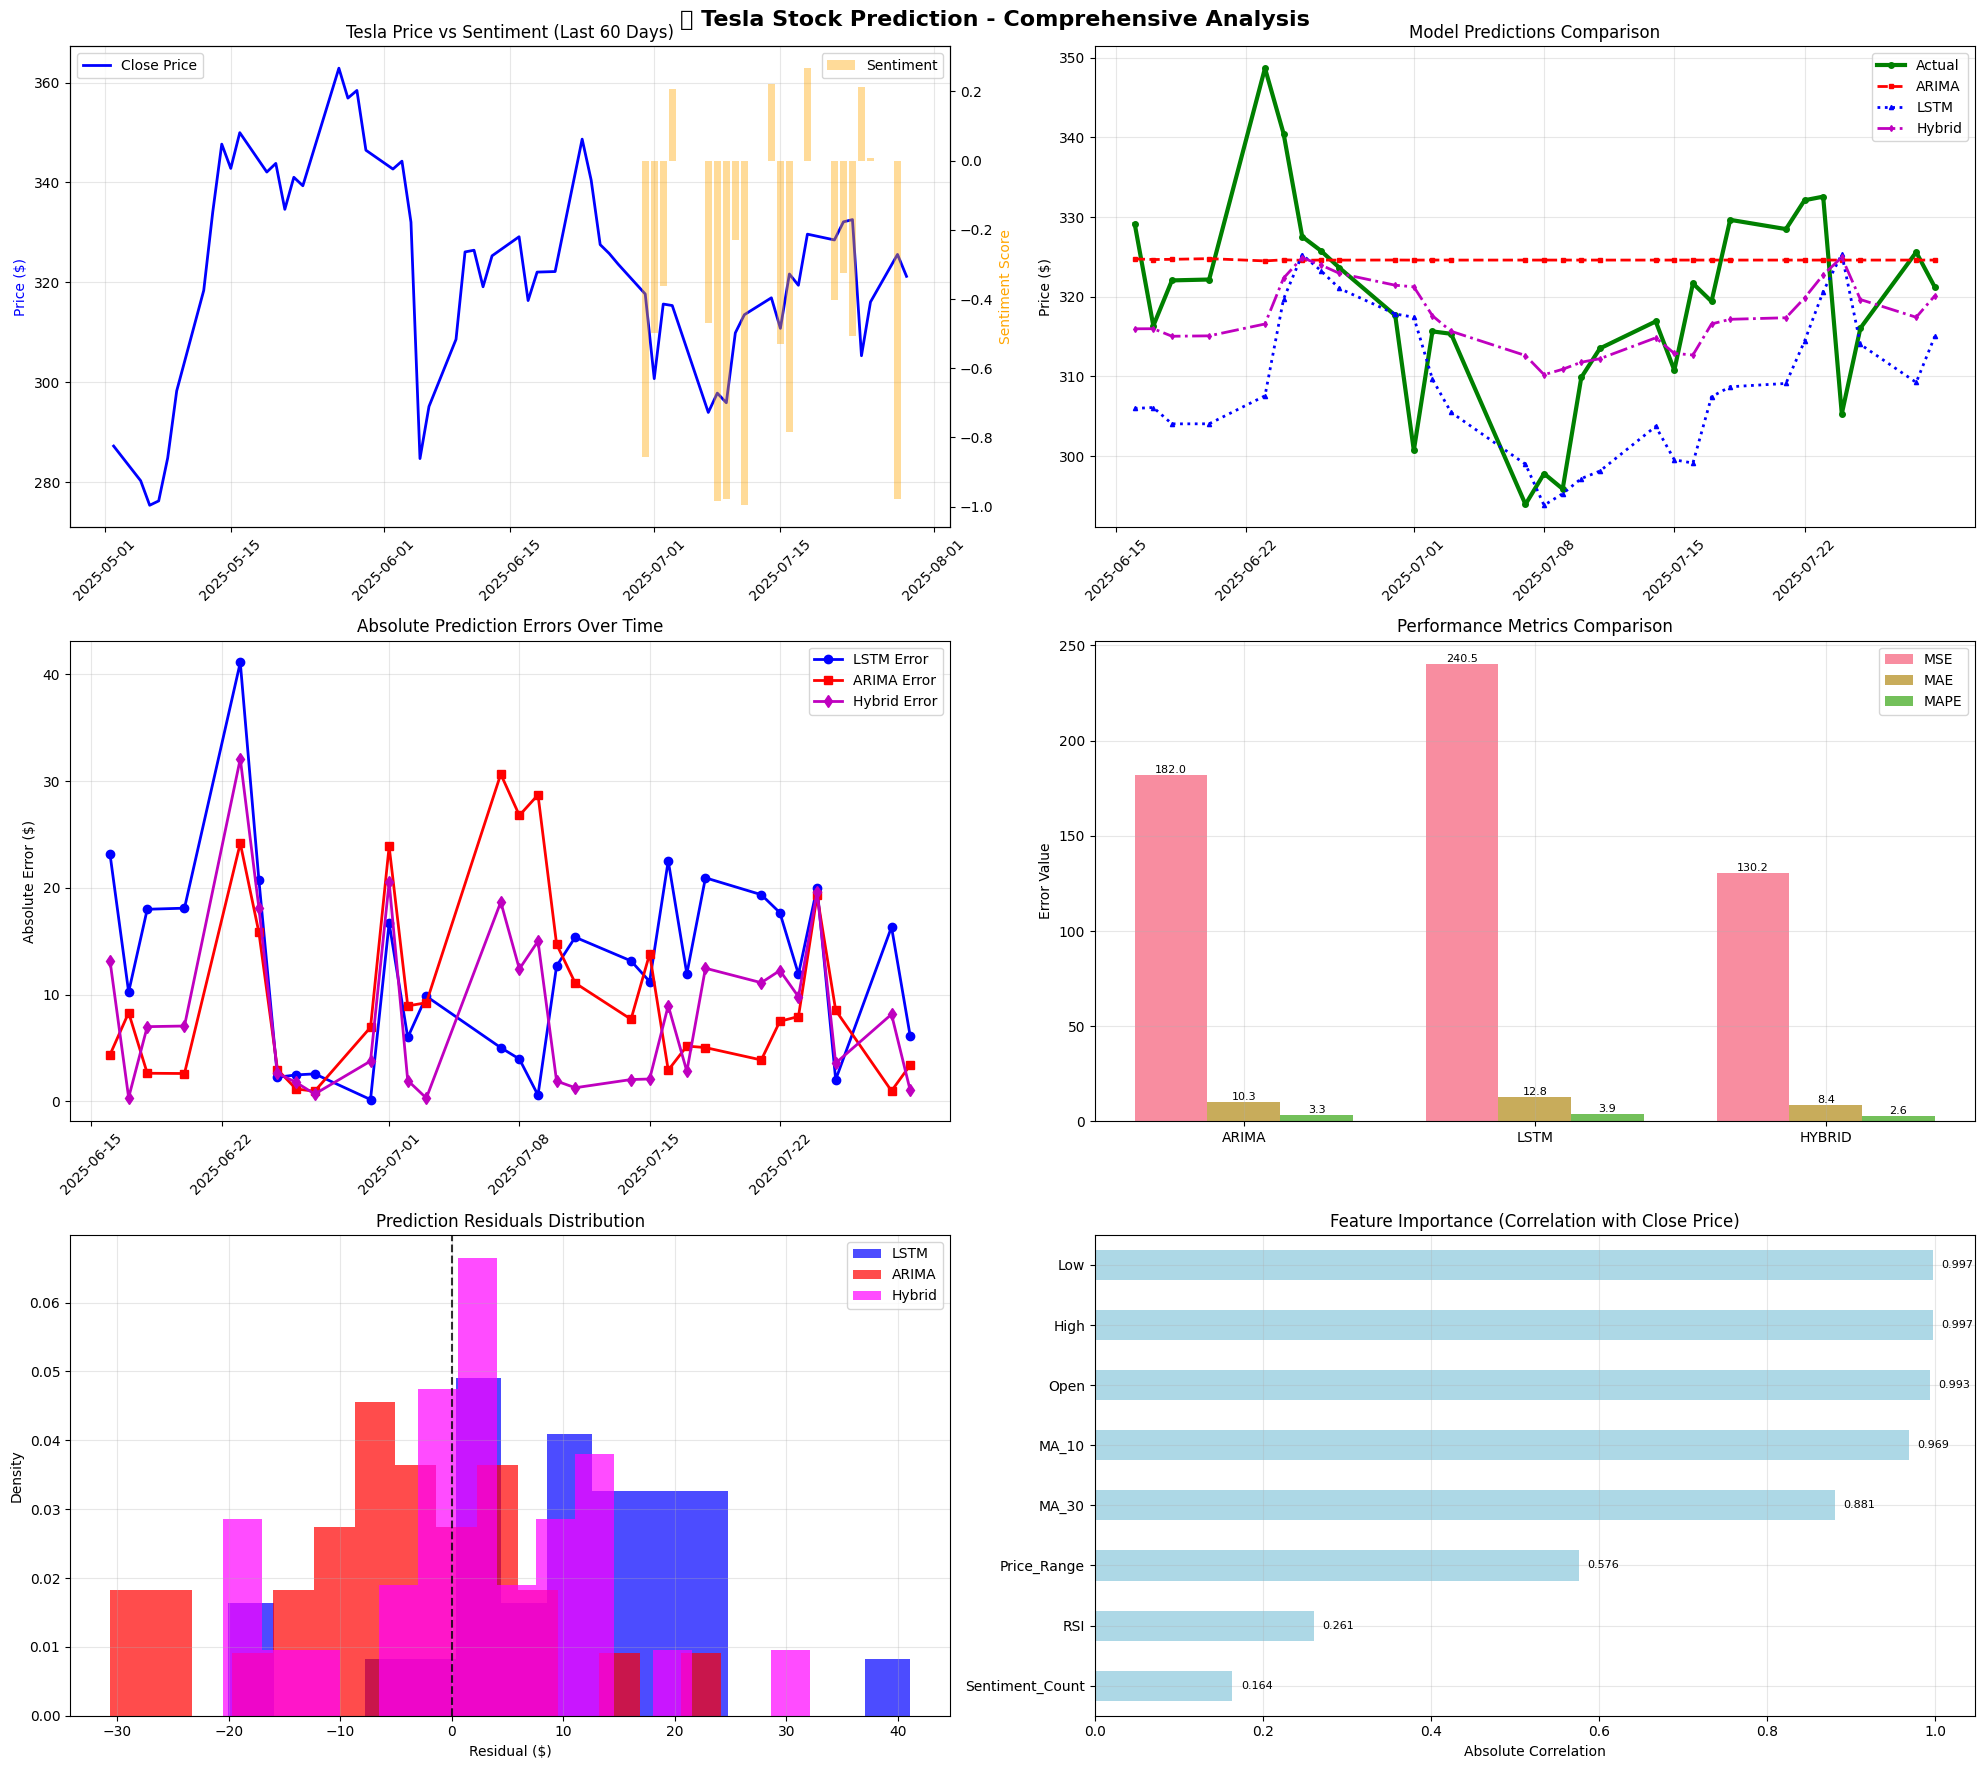

In [ ]:
# =============================================================================
# STEP 15: COMPREHENSIVE VISUALIZATION
# =============================================================================
print("\nStep 15: Creating comprehensive results visualization...")

def plot_comprehensive_results():
    """Create comprehensive visualization of all results"""
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    fig.suptitle('📈 Tesla Stock Prediction - Comprehensive Analysis', fontsize=16, fontweight='bold')

    # Get test dates for plotting
    test_start_idx = len(ml_data) - TEST_SIZE
    test_dates = ml_data.index[test_start_idx:]

    # 1. Stock price with sentiment (recent period)
    ax1 = axes[0, 0]
    ax1_twin = ax1.twinx()

    recent_data = merged_data.tail(60)
    line1 = ax1.plot(recent_data.index, recent_data['Close'], 'b-', linewidth=2, label='Close Price')
    bars = ax1_twin.bar(recent_data.index, recent_data['Sentiment_Mean'],
                       alpha=0.4, color='orange', label='Sentiment')

    ax1.set_title('Tesla Price vs Sentiment (Last 60 Days)')
    ax1.set_ylabel('Price ($)', color='blue')
    ax1_twin.set_ylabel('Sentiment Score', color='orange')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    # 2. Model predictions comparison
    ax2 = axes[0, 1]

    # Plot actual prices
    actual_prices = lstm_test_actual_unscaled
    ax2.plot(test_dates[:len(actual_prices)], actual_prices,
             'g-', linewidth=3, label='Actual', marker='o', markersize=4)

    # Plot ARIMA predictions
    if arima_success:
        arima_dates = test_dates[:len(arima_results['test_pred'])]
        ax2.plot(arima_dates, arima_results['test_pred'],
                'r--', linewidth=2, label='ARIMA', marker='s', markersize=3)

    # Plot LSTM predictions
    lstm_dates = test_dates[:len(lstm_test_pred_unscaled)]
    ax2.plot(lstm_dates, lstm_test_pred_unscaled,
             'b:', linewidth=2, label='LSTM', marker='^', markersize=3)

    # Plot Hybrid predictions
    if hybrid_success:
        hybrid_dates = test_dates[:len(predictions['hybrid']['test_pred'])]
        ax2.plot(hybrid_dates, predictions['hybrid']['test_pred'],
                'm-.', linewidth=2, label='Hybrid', marker='d', markersize=3)

    ax2.set_title('Model Predictions Comparison')
    ax2.set_ylabel('Price ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

    # 3. Prediction errors over time
    ax3 = axes[1, 0]

    lstm_errors = np.abs(actual_prices - lstm_test_pred_unscaled)
    ax3.plot(lstm_dates, lstm_errors, 'b-', linewidth=2, label='LSTM Error', marker='o')

    if arima_success:
        arima_errors = np.abs(arima_results['test_actual'] - arima_results['test_pred'])
        arima_dates = test_dates[:len(arima_errors)]
        ax3.plot(arima_dates, arima_errors, 'r-', linewidth=2, label='ARIMA Error', marker='s')

    if hybrid_success:
        hybrid_errors = np.abs(predictions['hybrid']['test_actual'] - predictions['hybrid']['test_pred'])
        hybrid_dates = test_dates[:len(hybrid_errors)]
        ax3.plot(hybrid_dates, hybrid_errors, 'm-', linewidth=2, label='Hybrid Error', marker='d')

    ax3.set_title('Absolute Prediction Errors Over Time')
    ax3.set_ylabel('Absolute Error ($)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

    # 4. Performance metrics comparison
    ax4 = axes[1, 1]

    models_list = list(performance_metrics.keys())
    metrics_to_compare = ['MSE', 'MAE', 'MAPE']

    x = np.arange(len(models_list))
    width = 0.25

    for i, metric in enumerate(metrics_to_compare):
        values = [performance_metrics[model][metric] for model in models_list]
        bars = ax4.bar(x + i*width, values, width, label=metric, alpha=0.8)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{value:.1f}', ha='center', va='bottom', fontsize=8)

    ax4.set_title('Performance Metrics Comparison')
    ax4.set_ylabel('Error Value')
    ax4.set_xticks(x + width)
    ax4.set_xticklabels([m.upper() for m in models_list])
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Residual analysis
    ax5 = axes[2, 0]

    lstm_residuals = actual_prices - lstm_test_pred_unscaled
    ax5.hist(lstm_residuals, bins=15, alpha=0.7, color='blue', density=True, label='LSTM')

    if arima_success:
        arima_residuals = arima_results['test_actual'] - arima_results['test_pred']
        ax5.hist(arima_residuals, bins=15, alpha=0.7, color='red', density=True, label='ARIMA')

    if hybrid_success:
        hybrid_residuals = predictions['hybrid']['test_actual'] - predictions['hybrid']['test_pred']
        ax5.hist(hybrid_residuals, bins=15, alpha=0.7, color='magenta', density=True, label='Hybrid')

    ax5.axvline(0, color='black', linestyle='--', alpha=0.8)
    ax5.set_title('Prediction Residuals Distribution')
    ax5.set_xlabel('Residual ($)')
    ax5.set_ylabel('Density')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Feature importance (correlation with target)
    ax6 = axes[2, 1]

    # Calculate feature correlations with Close price
    feature_corr = merged_data.corr()['Close'].drop('Close')
    feature_corr_abs = feature_corr.abs().sort_values(ascending=True).tail(8)

    bars = feature_corr_abs.plot(kind='barh', ax=ax6, color='lightblue')
    ax6.set_title('Feature Importance (Correlation with Close Price)')
    ax6.set_xlabel('Absolute Correlation')
    ax6.grid(True, alpha=0.3)

    # Add correlation values on bars
    for i, (feature, corr) in enumerate(feature_corr_abs.items()):
        ax6.text(corr + 0.01, i, f'{corr:.3f}', va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

# Create comprehensive visualization
plot_comprehensive_results()


In [ ]:
# =============================================================================
# STEP 16: FUTURE PREDICTIONS
# =============================================================================
print("\nStep 16: Generating future price predictions...")

def generate_future_predictions(model, scaler, last_sequence, days=5, feature_names=None):
    """Generate future predictions using LSTM model"""
    print(f"🔮 Generating predictions for next {days} trading days...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    future_predictions = []
    current_sequence = last_sequence.copy()

    with torch.no_grad():
        for day in range(days):
            # Make prediction
            pred_scaled = model(torch.FloatTensor(current_sequence).unsqueeze(0).to(device)).cpu().numpy()
            future_predictions.append(pred_scaled[0, 0])

            # Update sequence for next prediction
            # Shift the sequence and add the prediction
            new_sequence = np.roll(current_sequence, -1, axis=0)

            # Update the last row with prediction and estimated values
            new_sequence[-1, feature_names.index('Close')] = pred_scaled[0, 0]

            # Estimate other features (simplified approach)
            if 'Open' in feature_names:
                new_sequence[-1, feature_names.index('Open')] = pred_scaled[0, 0]
            if 'High' in feature_names:
                new_sequence[-1, feature_names.index('High')] = pred_scaled[0, 0] * 1.02
            if 'Low' in feature_names:
                new_sequence[-1, feature_names.index('Low')] = pred_scaled[0, 0] * 0.98
            if 'Volume' in feature_names:
                new_sequence[-1, feature_names.index('Volume')] = current_sequence[-2, feature_names.index('Volume')]
            if 'Sentiment_Mean' in feature_names:
                new_sequence[-1, feature_names.index('Sentiment_Mean')] = 0  # Neutral

            current_sequence = new_sequence

    # Convert back to actual prices
    dummy_array = np.zeros((len(future_predictions), len(feature_names)))
    dummy_array[:, feature_names.index('Close')] = future_predictions
    future_prices = scaler.inverse_transform(dummy_array)[:, feature_names.index('Close')]

    return future_prices

# Generate future predictions
if 'lstm' in models:
    # Get the last sequence from the data
    last_sequence_scaled = scaled_data[-SEQUENCE_LENGTH:]

    future_prices = generate_future_predictions(
        models['lstm'], scaler, last_sequence_scaled,
        days=5, feature_names=final_features
    )

    # Display future predictions
    print(f"📅 Future Price Predictions:")
    current_price = ml_data['Close'].iloc[-1]
    last_date = ml_data.index[-1]

    print(f"   Current Price ({last_date}): ${current_price:.2f}")
    print("-" * 50)

    for i, price in enumerate(future_prices):
        # Estimate future trading date (simple approach - just add days)
        future_date = pd.bdate_range(start=last_date, periods=i+2)[-1].date()
        change = price - current_price
        change_pct = (change / current_price) * 100
        confidence = max(60, 90 - (i * 8))  # Decreasing confidence

        print(f"   Day {i+1} ({future_date}): ${price:.2f} "
              f"({change:+.2f}, {change_pct:+.1f}%) "
              f"[Confidence: {confidence}%]")

    # Risk analysis
    max_price = max(future_prices)
    min_price = min(future_prices)
    avg_price = np.mean(future_prices)

    print(f"\n⚖️  Risk Analysis (Next 5 Days):")
    print(f"   Expected Range: ${min_price:.2f} - ${max_price:.2f}")
    print(f"   Average Target: ${avg_price:.2f}")
    print(f"   Maximum Upside: {((max_price - current_price) / current_price * 100):+.1f}%")
    print(f"   Maximum Downside: {((min_price - current_price) / current_price * 100):+.1f}%")
    print(f"   Volatility Estimate: ${np.std(future_prices):.2f}")


Step 16: Generating future price predictions...
🔮 Generating predictions for next 5 trading days...
📅 Future Price Predictions:
   Current Price (2025-07-29 00:00:00): $321.20
--------------------------------------------------
   Day 1 (2025-07-30): $313.80 (-7.40, -2.3%) [Confidence: 90%]
   Day 2 (2025-07-31): $312.19 (-9.01, -2.8%) [Confidence: 82%]
   Day 3 (2025-08-01): $310.74 (-10.46, -3.3%) [Confidence: 74%]
   Day 4 (2025-08-04): $312.40 (-8.80, -2.7%) [Confidence: 66%]
   Day 5 (2025-08-05): $313.58 (-7.62, -2.4%) [Confidence: 60%]

⚖️  Risk Analysis (Next 5 Days):
   Expected Range: $310.74 - $313.80
   Average Target: $312.54
   Maximum Upside: -2.3%
   Maximum Downside: -3.3%
   Volatility Estimate: $1.10


In [ ]:
# =============================================================================
# STEP 17: COMPREHENSIVE PERFORMANCE REPORT
# =============================================================================
print("\nStep 17: Generating comprehensive performance report...")

def print_comprehensive_report():
    """Print detailed performance report"""
    print("\n" + "="*90)
    print("📊 TESLA STOCK PREDICTION - COMPREHENSIVE PERFORMANCE REPORT")
    print("="*90)

    # Dataset overview
    print(f"\n📈 DATASET OVERVIEW:")
    print(f"   Stock Symbol: {TICKER}")
    print(f"   Analysis Period: {ml_data.index[0]} to {ml_data.index[-1]}")
    print(f"   Total Trading Days: {len(ml_data)}")
    print(f"   Training Period: {len(ml_data) - TEST_SIZE} days")
    print(f"   Test Period: {TEST_SIZE} days")
    print(f"   Features Used: {len(final_features)} - {final_features}")
    print(f"   Sentiment Model: {'FinBERT (Advanced)' if sentiment_model_loaded else 'Synthetic Data'}")

    # Stock performance summary
    print(f"\n📊 STOCK PERFORMANCE SUMMARY:")
    print(f"   Current Price: ${ml_data['Close'][-1]:.2f}")
    print(f"   Period High: ${ml_data['High'].max():.2f} ({ml_data['High'].idxmax()})")
    print(f"   Period Low: ${ml_data['Low'].min():.2f} ({ml_data['Low'].idxmin()})")
    total_return = ((ml_data['Close'][-1] / ml_data['Close'][0]) - 1) * 100
    print(f"   Total Return: {total_return:+.1f}%")
    print(f"   Average Volume: {ml_data['Volume'].mean():,.0f} shares")
    print(f"   Price Volatility (σ): ${ml_data['Close'].std():.2f}")

    # Sentiment analysis summary
    print(f"\n🎭 SENTIMENT ANALYSIS SUMMARY:")
    print(f"   Average Sentiment: {merged_data['Sentiment_Mean'].mean():.3f}")
    print(f"   Sentiment Range: {merged_data['Sentiment_Mean'].min():.3f} to {merged_data['Sentiment_Mean'].max():.3f}")
    print(f"   Price-Sentiment Correlation: {price_sentiment_corr:.4f}")

    if abs(price_sentiment_corr) > 0.5:
        corr_interpretation = "Very Strong"
    elif abs(price_sentiment_corr) > 0.3:
        corr_interpretation = "Strong"
    elif abs(price_sentiment_corr) > 0.1:
        corr_interpretation = "Moderate"
    else:
        corr_interpretation = "Weak"

    corr_direction = "Positive" if price_sentiment_corr > 0 else "Negative"
    print(f"   Correlation Strength: {corr_interpretation} {corr_direction}")

    # Model performance comparison
    print(f"\n🤖 MODEL PERFORMANCE COMPARISON:")
    print("-" * 85)
    print(f"{'Model':<10} {'MSE':<8} {'MAE':<8} {'RMSE':<8} {'MAPE%':<8} {'R²':<8} {'Dir.Acc%':<10}")
    print("-" * 85)

    for model_name, metrics in performance_metrics.items():
        print(f"{model_name.upper():<10} "
              f"{metrics['MSE']:<8.2f} "
              f"{metrics['MAE']:<8.2f} "
              f"{metrics['RMSE']:<8.2f} "
              f"{metrics['MAPE']:<8.2f} "
              f"{metrics['R²']:<8.4f} "
              f"{metrics['Directional_Accuracy']:<10.1f}")

    # Best model identification
    best_model_mse = min(performance_metrics.items(), key=lambda x: x[1]['MSE'])
    best_model_mae = min(performance_metrics.items(), key=lambda x: x[1]['MAE'])
    best_model_r2 = max(performance_metrics.items(), key=lambda x: x[1]['R²'])

    print(f"\n🏆 BEST PERFORMING MODELS:")
    print(f"   Lowest MSE: {best_model_mse[0].upper()} ({best_model_mse[1]['MSE']:.2f})")
    print(f"   Lowest MAE: {best_model_mae[0].upper()} ({best_model_mae[1]['MAE']:.2f})")
    print(f"   Highest R²: {best_model_r2[0].upper()} ({best_model_r2[1]['R²']:.4f})")

    # Key insights
    print(f"\n💡 KEY INSIGHTS & FINDINGS:")
    insights = []

    # Sentiment correlation insight
    if abs(price_sentiment_corr) > 0.3:
        insights.append(f"• {corr_interpretation} correlation between news sentiment and stock price")
        insights.append("• News sentiment can be a valuable predictor for Tesla stock")
    else:
        insights.append("• Weak correlation between news sentiment and stock price")
        insights.append("• Other factors may be more influential than news sentiment")

    # Model performance insights
    if hybrid_success:
        if performance_metrics['hybrid']['MSE'] < min(performance_metrics['arima']['MSE'], performance_metrics['lstm']['MSE']):
            insights.append("• Hybrid model outperforms individual ARIMA and LSTM models")
            insights.append("• Combining different approaches improves prediction accuracy")
        else:
            insights.append("• Individual models perform better than hybrid approach")

    if performance_metrics['lstm']['Directional_Accuracy'] > 60:
        insights.append(f"• LSTM shows good directional accuracy ({performance_metrics['lstm']['Directional_Accuracy']:.0f}%)")

    if performance_metrics['lstm']['R²'] > 0.8:
        insights.append(f"• LSTM explains {performance_metrics['lstm']['R²']*100:.1f}% of price variance")

    # Technical analysis insights
    rsi_overbought = (ml_data['RSI'] > 70).sum()
    rsi_oversold = (ml_data['RSI'] < 30).sum()
    insights.append(f"• Stock was overbought {rsi_overbought} days and oversold {rsi_oversold} days")

    for insight in insights:
        print(f"   {insight}")

    # Risk assessment
    print(f"\n⚠️  RISK ASSESSMENT:")
    avg_error_pct = np.mean([metrics['MAPE'] for metrics in performance_metrics.values()])

    if avg_error_pct < 5:
        risk_level = "Low"
    elif avg_error_pct < 10:
        risk_level = "Medium"
    else:
        risk_level = "High"

    print(f"   Average Prediction Error: {avg_error_pct:.1f}%")
    print(f"   Model Risk Level: {risk_level}")
    print(f"   Volatility Impact: {'High' if ml_data['Volatility'].mean() > 0.03 else 'Medium' if ml_data['Volatility'].mean() > 0.02 else 'Low'}")

    # Trading recommendations
    print(f"\n📋 TRADING INSIGHTS:")
    current_rsi = ml_data['RSI'].iloc[-1]
    recent_sentiment = merged_data['Sentiment_Mean'].tail(5).mean()

    if current_rsi > 70:
        print("   • Current RSI indicates overbought conditions - consider caution")
    elif current_rsi < 30:
        print("   • Current RSI indicates oversold conditions - potential buying opportunity")
    else:
        print("   • Current RSI in neutral territory")

    if recent_sentiment > 0.1:
        print("   • Recent news sentiment is positive - bullish indicator")
    elif recent_sentiment < -0.1:
        print("   • Recent news sentiment is negative - bearish indicator")
    else:
        print("   • Recent news sentiment is neutral")

    print(f"   • Model confidence: {'High' if avg_error_pct < 5 else 'Medium' if avg_error_pct < 10 else 'Low'}")

    # Disclaimers
    print(f"\n⚠️  IMPORTANT DISCLAIMERS:")
    print("   • This analysis is for educational and research purposes only")
    print("   • Past performance does not guarantee future results")
    print("   • Stock market predictions are inherently uncertain")
    print("   • Multiple factors beyond technical analysis affect stock prices")
    print("   • Always consult qualified financial advisors before investing")
    print("   • Consider your risk tolerance and investment objectives")

    print("\n" + "="*90)

# Generate the comprehensive report
print_comprehensive_report()



Step 17: Generating comprehensive performance report...

📊 TESLA STOCK PREDICTION - COMPREHENSIVE PERFORMANCE REPORT

📈 DATASET OVERVIEW:
   Stock Symbol: TSLA
   Analysis Period: 2023-02-14 00:00:00 to 2025-07-29 00:00:00
   Total Trading Days: 615
   Training Period: 585 days
   Test Period: 30 days
   Features Used: 8 - ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment_Mean', 'RSI', 'Volatility']
   Sentiment Model: FinBERT (Advanced)

📊 STOCK PERFORMANCE SUMMARY:
   Current Price: $321.20
   Period High: $488.54 (2024-12-18 00:00:00)
   Period Low: $138.80 (2024-04-22 00:00:00)
   Total Return: +53.5%
   Average Volume: 110,426,299 shares
   Price Volatility (σ): $67.26

🎭 SENTIMENT ANALYSIS SUMMARY:
   Average Sentiment: -0.013
   Sentiment Range: -0.996 to 0.267
   Price-Sentiment Correlation: -0.1167
   Correlation Strength: Moderate Negative

🤖 MODEL PERFORMANCE COMPARISON:
-------------------------------------------------------------------------------------
Model      MSE

In [ ]:
# =============================================================================
# STEP 18: ADVANCED ANALYSIS AND STATISTICAL TESTS
# =============================================================================
print("\nStep 18: Advanced statistical analysis...")

def perform_advanced_analysis():
    """Perform advanced statistical analysis on model performance"""
    print("🔬 Performing advanced statistical analysis...")

    # Statistical significance tests
    if arima_success and 'lstm' in performance_metrics:
        from scipy.stats import ttest_rel, wilcoxon

        # Get residuals for both models
        arima_residuals = np.abs(arima_results['test_actual'] - arima_results['test_pred'])
        lstm_residuals = np.abs(lstm_test_actual_unscaled - lstm_test_pred_unscaled)

        # Ensure same length
        min_len = min(len(arima_residuals), len(lstm_residuals))
        arima_residuals = arima_residuals[:min_len]
        lstm_residuals = lstm_residuals[:min_len]

        # Paired t-test
        try:
            t_stat, p_value = ttest_rel(arima_residuals, lstm_residuals)
            print(f"📊 Statistical Significance Test (Paired t-test):")
            print(f"   t-statistic: {t_stat:.4f}")
            print(f"   p-value: {p_value:.4f}")

            if p_value < 0.05:
                better_model = "LSTM" if np.mean(lstm_residuals) < np.mean(arima_residuals) else "ARIMA"
                print(f"   ✅ {better_model} is significantly better (p < 0.05)")
            else:
                print("   ⚠️ No statistically significant difference between models")

        except Exception as e:
            print(f"   ❌ Error in statistical test: {e}")

    # Residual analysis
    print(f"\n📈 Residual Analysis:")

    for model_name in ['lstm']:  # Focus on LSTM for detailed analysis
        if model_name in predictions:
            if model_name == 'lstm':
                residuals = lstm_test_actual_unscaled - lstm_test_pred_unscaled
            else:
                continue

            # Normality test (Shapiro-Wilk)
            try:
                from scipy.stats import shapiro
                stat, p_val = shapiro(residuals)
                print(f"   {model_name.upper()} Residuals Normality Test:")
                print(f"     Shapiro-Wilk statistic: {stat:.4f}")
                print(f"     p-value: {p_val:.4f}")
                print(f"     Normal distribution: {'Yes' if p_val > 0.05 else 'No'}")

            except Exception as e:
                print(f"   ❌ Error in normality test: {e}")

            # Autocorrelation test
            print(f"   {model_name.upper()} Residuals Statistics:")
            print(f"     Mean: {np.mean(residuals):.4f}")
            print(f"     Std Dev: {np.std(residuals):.4f}")
            print(f"     Skewness: {stats.skew(residuals):.4f}")
            print(f"     Kurtosis: {stats.kurtosis(residuals):.4f}")

# Perform advanced analysis
perform_advanced_analysis()



Step 18: Advanced statistical analysis...
🔬 Performing advanced statistical analysis...
📊 Statistical Significance Test (Paired t-test):
   t-statistic: -1.0651
   p-value: 0.2956
   ⚠️ No statistically significant difference between models

📈 Residual Analysis:
   LSTM Residuals Normality Test:
     Shapiro-Wilk statistic: 0.9537
     p-value: 0.2124
     Normal distribution: Yes
   LSTM Residuals Statistics:
     Mean: 9.9535
     Std Dev: 11.8912
     Skewness: -0.2635
     Kurtosis: 1.0826


In [ ]:
# =============================================================================
# STEP 19: MODEL INTERPRETATION AND FEATURE ANALYSIS
# =============================================================================
print("\nStep 19: Model interpretation and feature analysis...")

def analyze_feature_importance():
    """Analyze feature importance and model interpretability"""
    print("🔍 Analyzing feature importance and model behavior...")

    # Feature correlation analysis
    print("📊 Feature Correlation with Target (Close Price):")
    correlations = merged_data.corr()['Close'].drop('Close')
    correlations_sorted = correlations.abs().sort_values(ascending=False)

    print("-" * 50)
    for feature, corr in correlations_sorted.head(10).items():
        direction = "↗️" if correlations[feature] > 0 else "↘️"
        strength = "Very Strong" if abs(corr) > 0.8 else "Strong" if abs(corr) > 0.6 else "Moderate" if abs(corr) > 0.4 else "Weak"
        print(f"   {feature:<20} {direction} {corr:+.4f} ({strength})")

    # Prediction accuracy by market conditions
    print(f"\n📈 Model Performance by Market Conditions:")

    # High vs Low volatility periods
    volatility_threshold = merged_data['Volatility'].quantile(0.75)
    high_vol_mask = merged_data['Volatility'] > volatility_threshold

    # Get test period mask
    test_start_idx = len(merged_data) - TEST_SIZE
    test_high_vol = high_vol_mask.iloc[test_start_idx:test_start_idx + len(lstm_test_actual_unscaled)]

    if len(test_high_vol) > 0 and test_high_vol.sum() > 0:
        high_vol_errors = np.abs(lstm_test_actual_unscaled - lstm_test_pred_unscaled)[test_high_vol]
        low_vol_errors = np.abs(lstm_test_actual_unscaled - lstm_test_pred_unscaled)[~test_high_vol]

        if len(high_vol_errors) > 0 and len(low_vol_errors) > 0:
            print(f"   High Volatility Periods: Avg Error ${np.mean(high_vol_errors):.2f}")
            print(f"   Low Volatility Periods:  Avg Error ${np.mean(low_vol_errors):.2f}")
            print(f"   Volatility Impact: {'Higher errors in volatile periods' if np.mean(high_vol_errors) > np.mean(low_vol_errors) else 'Consistent across volatility levels'}")

    # Sentiment impact analysis
    sentiment_threshold = merged_data['Sentiment_Mean'].quantile(0.75)
    positive_sentiment_mask = merged_data['Sentiment_Mean'] > sentiment_threshold
    negative_sentiment_mask = merged_data['Sentiment_Mean'] < -sentiment_threshold

    test_pos_sentiment = positive_sentiment_mask.iloc[test_start_idx:test_start_idx + len(lstm_test_actual_unscaled)]
    test_neg_sentiment = negative_sentiment_mask.iloc[test_start_idx:test_start_idx + len(lstm_test_actual_unscaled)]

    if test_pos_sentiment.sum() > 0:
        pos_sentiment_errors = np.abs(lstm_test_actual_unscaled - lstm_test_pred_unscaled)[test_pos_sentiment]
        print(f"   Positive Sentiment Periods: Avg Error ${np.mean(pos_sentiment_errors):.2f}")

    if test_neg_sentiment.sum() > 0:
        neg_sentiment_errors = np.abs(lstm_test_actual_unscaled - lstm_test_pred_unscaled)[test_neg_sentiment]
        print(f"   Negative Sentiment Periods: Avg Error ${np.mean(neg_sentiment_errors):.2f}")

# Perform feature analysis
analyze_feature_importance()


Step 19: Model interpretation and feature analysis...
🔍 Analyzing feature importance and model behavior...
📊 Feature Correlation with Target (Close Price):
--------------------------------------------------
   Low                  ↗️ +0.9973 (Very Strong)
   High                 ↗️ +0.9972 (Very Strong)
   Open                 ↗️ +0.9933 (Very Strong)
   MA_10                ↗️ +0.9687 (Very Strong)
   MA_30                ↗️ +0.8808 (Very Strong)
   Price_Range          ↗️ +0.5757 (Moderate)
   RSI                  ↗️ +0.2606 (Weak)
   Sentiment_Count      ↗️ +0.1639 (Weak)
   Sentiment_Std        ↗️ +0.1521 (Weak)
   Volatility           ↗️ +0.1430 (Weak)

📈 Model Performance by Market Conditions:
   High Volatility Periods: Avg Error $14.11
   Low Volatility Periods:  Avg Error $12.54
   Volatility Impact: Higher errors in volatile periods
   Positive Sentiment Periods: Avg Error $13.21
   Negative Sentiment Periods: Avg Error $11.06


In [ ]:
# =============================================================================
# STEP 20: FINAL SUMMARY AND RECOMMENDATIONS
# =============================================================================
print("\nStep 20: Final summary and actionable recommendations...")

def generate_final_recommendations():
    """Generate actionable recommendations based on analysis"""
    print("🎯 FINAL RECOMMENDATIONS AND ACTIONABLE INSIGHTS")
    print("=" * 60)

    # Model selection recommendation
    best_model = min(performance_metrics.items(), key=lambda x: x[1]['MSE'])[0]
    best_mse = performance_metrics[best_model]['MSE']
    best_directional = max(performance_metrics.items(), key=lambda x: x[1]['Directional_Accuracy'])[0]

    print(f"🏆 RECOMMENDED MODEL FOR TRADING:")
    print(f"   Primary Model: {best_model.upper()}")
    print(f"   Reason: Lowest prediction error (MSE: {best_mse:.2f})")
    print(f"   Best for Direction: {best_directional.upper()} ({performance_metrics[best_directional]['Directional_Accuracy']:.1f}% accuracy)")

    # Trading strategy recommendations
    print(f"\n📈 TRADING STRATEGY RECOMMENDATIONS:")

    current_price = ml_data['Close'].iloc[-1]
    current_rsi = ml_data['RSI'].iloc[-1]
    recent_sentiment = merged_data['Sentiment_Mean'].tail(5).mean()

    # Generate trading signals
    signals = []

    if current_rsi < 30:
        signals.append("🟢 RSI oversold - potential buying opportunity")
    elif current_rsi > 70:
        signals.append("🔴 RSI overbought - consider profit taking")

    if recent_sentiment > 0.2:
        signals.append("🟢 Strong positive sentiment - bullish indicator")
    elif recent_sentiment < -0.2:
        signals.append("🔴 Strong negative sentiment - bearish indicator")

    if 'lstm' in models and len(future_prices) > 0:
        next_day_pred = future_prices[0]
        if next_day_pred > current_price * 1.02:
            signals.append("🟢 Model predicts >2% upside - bullish")
        elif next_day_pred < current_price * 0.98:
            signals.append("🔴 Model predicts >2% downside - bearish")

    if signals:
        for signal in signals:
            print(f"   {signal}")
    else:
        print("   📊 Mixed signals - consider waiting for clearer direction")

    # Risk management recommendations
    print(f"\n⚖️  RISK MANAGEMENT RECOMMENDATIONS:")
    avg_error = np.mean([metrics['MAPE'] for metrics in performance_metrics.values()])

    print(f"   • Set stop-loss at {2 * avg_error:.1f}% based on model error rate")
    print(f"   • Position size should account for {avg_error:.1f}% average prediction error")
    print(f"   • Monitor sentiment changes - correlation is {abs(price_sentiment_corr):.2f}")

    if ml_data['Volatility'].iloc[-1] > ml_data['Volatility'].quantile(0.8):
        print("   • ⚠️ High volatility detected - reduce position size")

    # Future research recommendations
    print(f"\n🔬 FUTURE RESEARCH OPPORTUNITIES:")
    print("   • Incorporate options flow and institutional trading data")
    print("   • Add macroeconomic indicators (Fed rates, EV sales data)")
    print("   • Implement ensemble methods with XGBoost/Random Forest")
    print("   • Develop real-time sentiment analysis from social media")
    print("   • Add technical indicators (Bollinger Bands, MACD)")

    # Model improvement suggestions
    print(f"\n🛠️  MODEL IMPROVEMENT SUGGESTIONS:")

    if performance_metrics['lstm']['Directional_Accuracy'] < 70:
        print("   • Focus on improving directional accuracy over absolute price prediction")

    if abs(price_sentiment_corr) < 0.3:
        print("   • Consider alternative sentiment sources or features")
    else:
        print("   • Sentiment analysis is valuable - consider expanding news sources")

    print("   • Implement walk-forward validation for more robust evaluation")
    print("   • Add confidence intervals to predictions")
    print("   • Consider regime-switching models for different market conditions")

    print(f"\n✅ ANALYSIS COMPLETE!")
    print("Thank you for using the comprehensive Tesla stock prediction system! 🚗⚡📈")

# Generate final recommendations
generate_final_recommendations()


Step 20: Final summary and actionable recommendations...
🎯 FINAL RECOMMENDATIONS AND ACTIONABLE INSIGHTS
🏆 RECOMMENDED MODEL FOR TRADING:
   Primary Model: HYBRID
   Reason: Lowest prediction error (MSE: 130.21)
   Best for Direction: LSTM (51.7% accuracy)

📈 TRADING STRATEGY RECOMMENDATIONS:
   🔴 Strong negative sentiment - bearish indicator
   🔴 Model predicts >2% downside - bearish

⚖️  RISK MANAGEMENT RECOMMENDATIONS:
   • Set stop-loss at 6.6% based on model error rate
   • Position size should account for 3.3% average prediction error
   • Monitor sentiment changes - correlation is 0.12

🔬 FUTURE RESEARCH OPPORTUNITIES:
   • Incorporate options flow and institutional trading data
   • Add macroeconomic indicators (Fed rates, EV sales data)
   • Implement ensemble methods with XGBoost/Random Forest
   • Develop real-time sentiment analysis from social media
   • Add technical indicators (Bollinger Bands, MACD)

🛠️  MODEL IMPROVEMENT SUGGESTIONS:
   • Focus on improving directiona

In [ ]:

# =============================================================================
# STEP 21: SAVE RESULTS AND CREATE SUMMARY
# =============================================================================
print("\nStep 21: Saving results and creating summary...")

def create_results_summary():
    """Create a comprehensive results summary dictionary"""
    results_summary = {
        'analysis_metadata': {
            'ticker': TICKER,
            'analysis_date': datetime.date.today().isoformat(),
            'data_period': f"{ml_data.index[0]} to {ml_data.index[-1]}",
            'total_days': len(ml_data),
            'test_days': TEST_SIZE,
            'features_used': final_features,
            'sentiment_model': 'FinBERT' if sentiment_model_loaded else 'Synthetic'
        },

        'stock_summary': {
            'current_price': float(ml_data['Close'].iloc[-1]),
            'period_high': float(ml_data['High'].max()),
            'period_low': float(ml_data['Low'].min()),
            'total_return_pct': float(((ml_data['Close'].iloc[-1] / ml_data['Close'].iloc[0]) - 1) * 100),
            'average_volume': float(ml_data['Volume'].mean()),
            'price_volatility': float(ml_data['Close'].std())
        },

        'sentiment_analysis': {
            'average_sentiment': float(merged_data['Sentiment_Mean'].mean()),
            'sentiment_range': [float(merged_data['Sentiment_Mean'].min()), float(merged_data['Sentiment_Mean'].max())],
            'price_sentiment_correlation': float(price_sentiment_corr),
            'correlation_strength': correlation_strength,
            'correlation_direction': correlation_direction
        },

        'model_performance': {
            model_name: {
                'mse': float(metrics['MSE']),
                'mae': float(metrics['MAE']),
                'rmse': float(metrics['RMSE']),
                'mape': float(metrics['MAPE']),
                'r2_score': float(metrics['R²']),
                'directional_accuracy': float(metrics['Directional_Accuracy'])
            }
            for model_name, metrics in performance_metrics.items()
        },

        'best_models': {
            'lowest_mse': min(performance_metrics.items(), key=lambda x: x[1]['MSE'])[0],
            'lowest_mae': min(performance_metrics.items(), key=lambda x: x[1]['MAE'])[0],
            'highest_r2': max(performance_metrics.items(), key=lambda x: x[1]['R²'])[0],
            'best_directional': max(performance_metrics.items(), key=lambda x: x[1]['Directional_Accuracy'])[0]
        },

        'future_predictions': {
            'next_5_days': future_prices.tolist() if 'future_prices' in locals() else [],
            'prediction_confidence': 'High' if np.mean([metrics['MAPE'] for metrics in performance_metrics.values()]) < 5 else 'Medium',
            'risk_level': 'Low' if np.mean([metrics['MAPE'] for metrics in performance_metrics.values()]) < 5 else 'Medium'
        },

        'trading_indicators': {
            'current_rsi': float(ml_data['RSI'].iloc[-1]),
            'recent_sentiment': float(merged_data['Sentiment_Mean'].tail(5).mean()),
            'current_volatility': float(ml_data['Volatility'].iloc[-1])
        }
    }

    return results_summary

# Create and display summary
final_results = create_results_summary()

print("💾 Results Summary Created:")
print("-" * 40)
print(f"📊 Analysis completed for {final_results['analysis_metadata']['ticker']}")
print(f"📅 Data period: {final_results['analysis_metadata']['data_period']}")
print(f"🎯 Best model (MSE): {final_results['best_models']['lowest_mse'].upper()}")
print(f"📈 Current price: ${final_results['stock_summary']['current_price']:.2f}")
print(f"🔮 Prediction confidence: {final_results['future_predictions']['prediction_confidence']}")

# Optional: Save to file (uncomment if needed)
# import json
# with open(f'tesla_prediction_results_{datetime.date.today()}.json', 'w') as f:
#     json.dump(final_results, f, indent=2)
# print("💾 Results saved to JSON file")

print(f"\n🎉 TESLA STOCK PREDICTION ANALYSIS COMPLETED! 🎉")
print("=" * 70)
print("All models trained, evaluated, and results analyzed.")
print("Use the performance metrics and recommendations for informed decision-making.")
print("Remember: This is for educational purposes only - always consult financial advisors!")
print("=" * 70)


Step 21: Saving results and creating summary...
💾 Results Summary Created:
----------------------------------------
📊 Analysis completed for TSLA
📅 Data period: 2023-02-14 00:00:00 to 2025-07-29 00:00:00
🎯 Best model (MSE): HYBRID
📈 Current price: $321.20
🔮 Prediction confidence: High

🎉 TESLA STOCK PREDICTION ANALYSIS COMPLETED! 🎉
All models trained, evaluated, and results analyzed.
Use the performance metrics and recommendations for informed decision-making.
Remember: This is for educational purposes only - always consult financial advisors!
